In [1]:
from config import llm_config
import random
from dotenv import load_dotenv
from autogen import AssistantAgent, ReasoningAgent, ThinkNode, UserProxyAgent, GroupChatManager, GroupChat, ConversableAgent

load_dotenv()

question = "What is the expected maximum dice value if you can roll a 6-sided dice three times?"
random.seed(1)  # setup seed for reproducibility

In [2]:
def last_meaningful_msg(sender: ConversableAgent, recipient: ConversableAgent, summary_args: dict):
    import warnings

    if sender == recipient:
        return "TERMINATE"

    summary = ""
    chat_messages = recipient.chat_messages[sender]

    for msg in reversed(chat_messages):
        try:
            content = msg["content"]
            if isinstance(content, str):
                summary = content.replace("TERMINATE", "")
            elif isinstance(content, list):
                # Remove the `TERMINATE` word in the content list.
                summary = "\n".join(x["text"].replace("TERMINATE", "") for x in content if isinstance(x, dict) and "text" in x)
            if summary.strip().rstrip():
                return summary
        except (IndexError, AttributeError) as e:
            warnings.warn(f"Cannot extract summary using last_msg: {e}. Using an empty str as summary.", UserWarning)
    return summary

In [3]:
lats_agent = ReasoningAgent(
    name="lats_agent",
    system_message="answer math questions",
    llm_config=llm_config,
    verbose=True,
    # setup small depth and simulations for conciseness.
    reason_config={
        "method": "lats",
        "nsim": 5,
        "max_depth": 4,
        "rating_scale": 100,
    },
)


user_proxy = UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    code_execution_config=False,
    max_consecutive_auto_reply=10,
)

ans = user_proxy.initiate_chat(lats_agent, message=question, summary_method=last_meaningful_msg)

user_proxy (to lats_agent):

What is the expected maximum dice value if you can roll a 6-sided dice three times?

--------------------------------------------------------------------------------
lats_agent (to tot_thinker):

## Here are some previous trajectories and reflections



---

# Question:
What is the expected maximum dice value if you can roll a 6-sided dice three times?
---

---
What are the possible next steps?

--------------------------------------------------------------------------------
tot_thinker (to lats_agent):

REFLECTION:
The previous steps seem to lack any clear analysis or interaction with the question provided. From the question, it is apparent that the user is inquiring about the expected maximum value when rolling a 6-sided die three times. However, there seems to be no attempt to either calculate or clarify the response within previous actions. Addressing the question accurately requires an understanding of probability and statistics related to maximum valu

In [4]:
print(ans.summary)

To address the question about the expected maximum value when rolling a 6-sided die three times, let's follow your structured process:

### Step 1: Reiterate the Question

The question is: **What is the expected maximum value if you can roll a 6-sided die three times?** This entails calculating the average highest value obtained from three independent rolls of a 6-sided die.

### Step 2: Step-by-Step Calculation of the Expected Maximum Value

To calculate the expected maximum \( E[M] \) when rolling the die three times, we'll use the probabilities associated with each possible maximum.

1. **Identify Possible Maximum Values**: The possible maximum values when rolling three 6-sided dice are 1, 2, 3, 4, 5, and 6.
   
2. **Calculate Probabilities**: For each maximum value \( k \):
   - The probability that the maximum of the three rolls is exactly \( k \) can be computed using:
   \[
   P(M = k) = P(M \leq k) - P(M \leq k - 1)
   \]
   where:
   \[
   P(M \leq k) = \left( \frac{k}{6} \rig

In [22]:
def find_best_path(node: dict) -> list:
    """
    Find the path to the node with highest score and depth.

    Args:
        node (dict): Current node in the tree

    Returns:
        list: List of nodes representing the best path
    """
    if not node.get("children"):
        return [node]

    # Find child with best score/depth using max() with a tuple key
    best_child = max(
        ((child, find_best_path(child)) for child in node["children"]),
        key=lambda x: (x[0].get("value", 0), len(x[1])),
    )[1]

    return [node] + best_child


def print_best_path(tree: dict):
    """
    Print the path with highest score and depth from root to leaf.

    Args:
        tree (dict): Dictionary representing the tree structure
    """
    best_path = find_best_path(tree)

    print("\nBest Reasoning Path:")
    print("=" * 70)

    for depth, node in enumerate(best_path):
        indent = "  " * depth
        content = node["content"]

        # For the final node (leaf), print full content after the tree
        if depth == len(best_path) - 1:
            preview = "{FINAL ANSWER}"
            print(f"{indent}├─ {preview}")
            if node.get("value"):
                print(f"{indent}│  Value: {node['value']:.3f}")
            print("\nFinal Detailed Answer:")
            print("=" * 70)
            print(content)
            continue

        print(f"{indent}├─ {content}")
        if node.get("value"):
            print(f"{indent}│  Value: {node['value']:.3f}")


# Usage
# Convert tree to dict and back to ThinkNode directly
data = lats_agent._root.to_dict()
print_best_path(data)


Best Reasoning Path:
├─ What is the expected maximum dice value if you can roll a 6-sided dice three times?
│  Value: 0.945
  ├─ Reiterate the question to ensure full understanding before proceeding to explain the calculations.
  │  Value: 0.965
    ├─ Walk through a step-by-step calculation of the expected maximum value, included detailed formulas and numerical breakdowns.
    │  Value: 0.980
      ├─ Provide a numerical example with specific outcomes from the three dice rolls to illustrate how the maximum value varies in practice.
      │  Value: 0.980
        ├─ TERMINATE - The question seems fully resolved with a well-structured answer provided previously.
        │  Value: 0.980
          ├─ {FINAL ANSWER}
          │  Value: 0.980

Final Detailed Answer:
To address the question about the expected maximum value when rolling a 6-sided die three times, let's follow your structured process:

### Step 1: Reiterate the Question

The question is: **What is the expected maximum value if

---


In [17]:
from autogen import filter_config, GroupChat, AssistantAgent, UserProxyAgent, GroupChatManager
from config import llm_config
from dotenv import load_dotenv
from autogen.graph_utils import visualize_speaker_transitions_dict

load_dotenv()

llm_config["config_list"] = filter_config(
    config_list=llm_config["config_list"],
    filter_dict={"model": ["gpt-4o-mini"]},
)
config_list = llm_config["config_list"]

In [18]:
task = """Add 1 to the number output by the previous role. If the previous number is 20, output "TERMINATE"."""

In [19]:
# agents configuration
engineer = AssistantAgent(
    name="Engineer",
    llm_config=llm_config,
    system_message=task,
    description="I am **ONLY** allowed to speak **immediately** after `Planner`, `Critic` and `Executor`.\nIf the last number mentioned by `Critic` is not a multiple of 5, the next speaker must be `Engineer`.",
)

planner = AssistantAgent(
    name="Planner",
    system_message=task,
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `User` or `Critic`.\nIf the last number mentioned by `Critic` is a multiple of 5, the next speaker must be `Planner`.",
)

executor = AssistantAgent(
    name="Executor",
    system_message=task,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("FINISH"),
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `Engineer`.\nIf the last number mentioned by `Engineer` is a multiple of 3, the next speaker can only be `Executor`.",
)

critic = AssistantAgent(
    name="Critic",
    system_message=task,
    llm_config=llm_config,
    description="I am **ONLY** allowed to speak **immediately** after `Engineer`.\nIf the last number mentioned by `Engineer` is not a multiple of 3, the next speaker can only be `Critic`.",
)

user_proxy = UserProxyAgent(
    name="User",
    system_message=task,
    code_execution_config=False,
    human_input_mode="NEVER",
    llm_config=False,
    description="Never select me as a speaker.",
)

In [20]:
graph_dict = {}
graph_dict[user_proxy] = [planner]
graph_dict[planner] = [engineer]
graph_dict[engineer] = [critic, executor]
graph_dict[critic] = [engineer, planner]
graph_dict[executor] = [engineer]
graph_dict

{<autogen.agentchat.user_proxy_agent.UserProxyAgent at 0x7fbaae244680>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedcecc0>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedcecc0>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>],
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaae244440>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaae244440>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>,
 <autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbaaedce390>: [<autogen.agentchat.assistant_agent.AssistantAgent at 0x7fbab101e900>]}

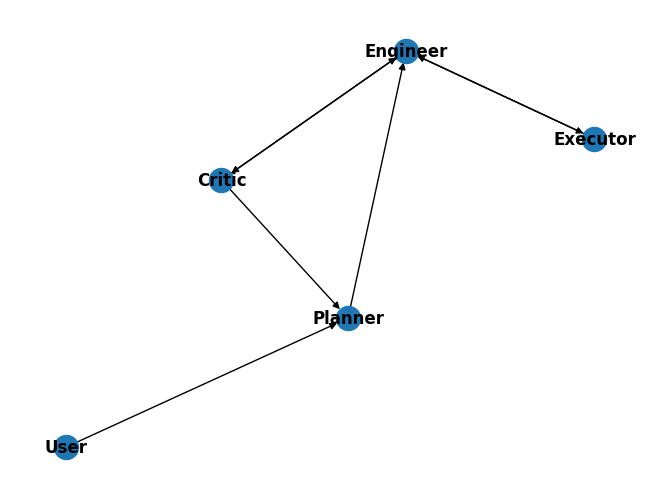

In [24]:
agents = [user_proxy, engineer, planner, executor, critic]
visualize_speaker_transitions_dict(graph_dict, agents)

In [15]:
agents = [user_proxy, engineer, planner, executor, critic]

# create the groupchat
group_chat = GroupChat(agents=agents, messages=[], max_round=25, allowed_or_disallowed_speaker_transitions=graph_dict, allow_repeat_speaker=None, speaker_transitions_type="allowed")

# create the manager
manager = GroupChatManager(
    groupchat=group_chat,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "") and x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,
)

In [16]:
# initiate the task
user_proxy.initiate_chat(manager, message="1", clear_history=True)

User (to chat_manager):

1

--------------------------------------------------------------------------------

Next speaker: Planner

Planner (to chat_manager):

2

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

3

--------------------------------------------------------------------------------

Next speaker: Executor

Executor (to chat_manager):

4

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

5

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

6

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

7

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

8

----------------

ChatResult(chat_id=None, chat_history=[{'content': '1', 'role': 'assistant', 'name': 'User'}, {'content': '2', 'name': 'Planner', 'role': 'user'}, {'content': '3', 'name': 'Engineer', 'role': 'user'}, {'content': '4', 'name': 'Executor', 'role': 'user'}, {'content': '5', 'name': 'Engineer', 'role': 'user'}, {'content': '6', 'name': 'Critic', 'role': 'user'}, {'content': '7', 'name': 'Engineer', 'role': 'user'}, {'content': '8', 'name': 'Critic', 'role': 'user'}, {'content': '9', 'name': 'Planner', 'role': 'user'}, {'content': '10', 'name': 'Engineer', 'role': 'user'}, {'content': '11', 'name': 'Critic', 'role': 'user'}, {'content': '12', 'name': 'Planner', 'role': 'user'}, {'content': '13', 'name': 'Engineer', 'role': 'user'}, {'content': '14', 'name': 'Executor', 'role': 'user'}, {'content': '15', 'name': 'Engineer', 'role': 'user'}, {'content': '16', 'name': 'Executor', 'role': 'user'}, {'content': '17', 'name': 'Engineer', 'role': 'user'}, {'content': '18', 'name': 'Executor', 'role